In [ ]:
# !pip install --upgrade transformers
# !pip install --upgrade datasets
# !pip -qq install  bitsandbytes
# !pip -qq install  peft

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
from peft import LoraConfig, PeftModel, PeftConfig
import pandas as pd
import torch
import json
import re
from pprint import pprint
import time
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer , BitsAndBytesConfig

In [ ]:
!huggingface-cli login

# Load Model

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer and model 
tokenizer = AutoTokenizer.from_pretrained("stabilityai/stablelm-3b-4e1t", use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained("stabilityai/stablelm-3b-4e1t", torch_dtype=torch.bfloat16,use_auth_token=True, trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [128]:
model = model.to("cuda:1")

# load dataset - cleaning

In [17]:
# Load the dataset from Hugging Face
huggingface_dataset_name = "Salesforce/dialogstudio"
dataset = load_dataset(huggingface_dataset_name, "TweetSumm")
dataset

DatasetDict({
    train: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
    test: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
})

In [9]:
from typing import List, Tuple, Dict
import json
import csv

class Turn:
    def __init__(self, is_agent: bool, sentences: List[str]):
        self._is_agent = is_agent
        self.sentences = sentences

    def is_agent(self):
        return self._is_agent

    def get_sentences(self):
        return self.sentences

    def get_json(self) -> str:
        return json.dumps({
            'is_agent': self.is_agent(),
            'sentences': self.sentences
        })

    def __str__(self):
        return ('Agent:\t' if self.is_agent() else 'Customer:\t') + ' '.join(self.sentences)


class Dialog:
    def __init__(self, dialog_id: str, turns: List[Turn]):
        self.dialog_id = dialog_id
        self.turns = turns

    def get_dialog_id(self) -> str:
        return self.dialog_id

    def get_turns(self) -> List[Turn]:
        return self.turns

    def get_json(self) -> str:
        turn_list = [json.loads(turn.get_json()) for turn in self.turns]
        return json.dumps({
            'dialog_id': self.dialog_id,
            'turns': turn_list
        })

    def __str__(self):
        result = self.dialog_id + '\n'
        for turn in self.turns:
            result += '\t' + str(turn) + '\n'
        return result


class DialogWithSummaries:
    def __init__(self, dialog_id: str, turns: List[Turn],
                 extractive_summaries: List[List[Turn]],
                 abstractive_summaries: List[List[str]]):
        self.dialog = Dialog(dialog_id, turns)
        self.extractive_summaries = extractive_summaries
        self.abstractive_summaries = abstractive_summaries

    def get_dialog(self) -> Dialog:
        return self.dialog

    def get_extractive_summaries(self) -> List[List[Turn]]:
        return self.extractive_summaries

    def get_abstractive_summaries(self) -> List[List[str]]:
        return self.abstractive_summaries

    def get_json(self) -> str:
        dialog = json.loads(self.dialog.get_json())
        extractive_summaries_json = [[json.loads(turn.get_json()) for turn in summary] for summary in self.extractive_summaries]
        abstractive_summaries_json = self.abstractive_summaries

        return json.dumps({
            'dialog': dialog,
            'summaries': {
                'extractive_summaries': extractive_summaries_json,
                'abstractive_summaries': abstractive_summaries_json
            }
        })

    def __str__(self):
        result = str(self.dialog) + '\nExtractive summaries:\n'
        for cnt, summary in enumerate(self.extractive_summaries):
            result += f'{cnt}:\n' + '\n'.join('\t' + str(turn) for turn in summary) + '\n'

        result += 'Abstractive summaries:\n'
        for cnt, summary in enumerate(self.abstractive_summaries):
            result += f'{cnt}:\n\t' + ' '.join(summary) + '\n'

        return result

In [10]:
from datasets import load_dataset
from typing import List
import json

class NewTweetSumProcessor:
    def __init__(self, dataset):
        self.dialogs = [self.process_dialog(dialog_data) for dialog_data in dataset]

    def process_dialog(self, dialog_data):
        dialog_id = dialog_data['new dialog id']
        original_dialog_info = json.loads(dialog_data['original dialog info'])
        turns = []
        for turn_data in dialog_data['log']:
            turns.extend(self.process_turn(turn_data))
        extractive_summaries = self.get_summaries(original_dialog_info['summaries']['extractive_summaries'])
        abstractive_summaries = original_dialog_info['summaries']['abstractive_summaries']
        return DialogWithSummaries(dialog_id, turns, extractive_summaries, abstractive_summaries)


    def process_turn(self, turn_data):
        turns = []

        # Add user utterance as a customer turn if present
        if 'user utterance' in turn_data and turn_data['user utterance']:
            turns.append(Turn(False, [turn_data['user utterance']]))

        # Add system response as an agent turn if present
        if 'system response' in turn_data and turn_data['system response']:
            turns.append(Turn(True, [turn_data['system response']]))

        return turns


    def get_summaries(self, extractive_summary_data):
        summaries = []
        for summary in extractive_summary_data:
            turns = [Turn(item['is_agent'], item['sentences']) for item in summary]
            summaries.append(turns)
        return summaries

In [11]:
processor = NewTweetSumProcessor(dataset['test'])  # or 'test', 'validation' 
dialogs = processor.dialogs

# Example of how to use the processed data
for dialog in dialogs[1:2]:  # Display first 5 dialogs for example
    print(dialog)

TweetSumm--test--2
	Customer:	@AirbnbHelp hi , my Acc was linked to an old number. Now I’m asked to verify my Acc , where a code / call wil be sent to my old number. Any way that I can link my Acc to my current number? Pls help
	Agent:	@637109 Hi there, we are here to help. We will have a specialist contact you about changing your phone number. Thank you.
	Customer:	@AirbnbHelp Thanks. Hope to get in touch soon
	Agent:	@637109 That is no problem. Please let us know if you have any further questions in the meantime.
	Customer:	@AirbnbHelp Hi sorry , is it for my account : __email__
	Agent:	@637109 Can you please delete this post as it does have personal info in it. We have updated your Case Manager https://t.co/WCQEFGIlXC @637109 who will be following up with you shortly. Feel free to DM us anytime with any other questions or concerns 2/2
	Customer:	@AirbnbHelp Thank you
	Agent:	@637109 That is no problem. Please do not hesitate to contact us with any further questions. Thank you.

Extr

In [14]:
import pandas as pd

def create_dataframe(processor):
    dialogues = []
    summaries = []

    for dialog in processor.dialogs:
        # Concatenate all turns into a single string for the dialogue column
        dialogue_str = '\n'.join(str(turn) for turn in dialog.get_dialog().get_turns())
        dialogues.append(dialogue_str)

        # Process and concatenate the first abstractive summary for the summary column
        if dialog.get_abstractive_summaries():  # Check if there are abstractive summaries
            first_summary = '\n'.join(dialog.get_abstractive_summaries()[0])
            summaries.append(first_summary)
        else:
            summaries.append('')  # If no abstractive summary, add an empty string

    return pd.DataFrame({'dialogue': dialogues, 'summary': summaries})

# Process the dataset
processor = NewTweetSumProcessor(dataset['train'])  # or 'test', 'validation' 
df = create_dataframe(processor)

# Save the DataFrame to a CSV file if needed
df.to_csv('train_dataset.csv', index=False)

In [16]:
example_indices = [10]

dash_line = '.'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(df.iloc[index]['dialogue'])  
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(df.iloc[index]['summary'])  
    print(dash_line)
    print()

...................................................................................................
Example  1
...................................................................................................
INPUT DIALOGUE:
Customer:	Bought these biscuits a couple of weeks ago, only just opened and looked at the best before date... @49975
Agent:	@393926 We can't see a picture of the best before date or biscuits attached to your tweets here. Please can you tweet or DM it to us again? Thanks. https://t.co/FqaAtoiNzs
Customer:	@marksandspencer  https://t.co/bjTjk67Tv1 @marksandspencer  https://t.co/W11bv0UVeA @marksandspencer  https://t.co/1MgEDf0cfM
Agent:	@393926 We'd certainly like to take a closer look into this. Please DM us a picture of your full receipt. https://t.co/FqaAto1cHU
Customer:	@marksandspencer Don’t have a receipt as they were bought for my grandparents 3 weeks ago and have only just realised the date on them @marksandspencer The biscuits were purchased at the Marks a

# zero-shot

In [21]:
for i, index in enumerate(example_indices):
    dialogue = df.iloc[index]['dialogue']
    summary = df.iloc[index]['summary']

    prompt = f"""
Summarize the following conversation accurately:{dialogue} 
Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = {key: value.to(model.device) for key, value in inputs.items()}  # Move inputs to the same device as the model

    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_length=500, 
            num_beams=1,
            temperature=0.8,
        )[0],
        skip_special_tokens=True
    )
    
    # Splitting the output to get only the summary
    split_output = output.split("Summary:")
    generated_summary = split_output[1].strip() if len(split_output) > 1 else "Summary not generated properly."

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


...................................................................................................
Example  1
...................................................................................................
INPUT PROMPT:

Summarize the following conversation accurately:Customer:	Bought these biscuits a couple of weeks ago, only just opened and looked at the best before date... @49975
Agent:	@393926 We can't see a picture of the best before date or biscuits attached to your tweets here. Please can you tweet or DM it to us again? Thanks. https://t.co/FqaAtoiNzs
Customer:	@marksandspencer  https://t.co/bjTjk67Tv1 @marksandspencer  https://t.co/W11bv0UVeA @marksandspencer  https://t.co/1MgEDf0cfM
Agent:	@393926 We'd certainly like to take a closer look into this. Please DM us a picture of your full receipt. https://t.co/FqaAto1cHU
Customer:	@marksandspencer Don’t have a receipt as they were bought for my grandparents 3 weeks ago and have only just realised the date on them @marksandspe

# One-shot

In [99]:
def one_shot_prompt(example=20, summarize=10):
    prompt = ''

    dialogue = df.iloc[example]['dialogue']
    summary = df.iloc[example]['summary']

    prompt += f"Summarize this conversation accurately:\n\n{dialogue}\n\nSummary:{summary}\n\n"

    dialogue = df.iloc[summarize]['dialogue']
    prompt += f"Summarize this conversation accurately:\n\n{dialogue}\n\nSummary:"
    
    return prompt

one_shot_prompt = one_shot_prompt()

print(one_shot_prompt)

Summarize this conversation accurately:

Customer:	@AmazonHelp why do y’all disconnect while in cut when you’re in the wrong? I’m so upset with your CS and would like to speak to a Supervisor
Agent:	@325154 I hate that this happened. Without providing personal info, can you tell us what's going on? We'd like to help if we can. ^AL
Customer:	@AmazonHelp Money was taken from my debit card for services I’ve never even used or received and now my money was put on another card? Yea ok @AmazonHelp How’d y’all take my money from one card but say you refunded it to a whole other card? &amp; don’t feel I should be compensated  your mishap😔🙁
Agent:	@325154 I'm sorry for the frustration so far. When you spoke with us, what insight was provided for you? ^SJ
Customer:	@AmazonHelp That I would have to locate where they “supposedly “ refunded it to. Why charge my card but not refund my card? Then just cut me off in chat
Agent:	@325154 I'm so sorry for the poor experience. We'd like another chance to 

In [100]:
summary = df.iloc[10]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
inputs = {key: value.to(model.device) for key, value in inputs.items()}  

# Existing code to generate the summary
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_length=847,
        num_beams=5,
        temperature=0.7,
        no_repeat_ngram_size=2
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


...................................................................................................
BASELINE HUMAN SUMMARY:
Customer bought a tin of biscuits and the use by date was old.
Wants a photo of the tin and date and how much they cost then they'll explain what happens next.

...................................................................................................
MODEL GENERATION - ONE SHOT:
Summarize this conversation accurately:

Customer:	@AmazonHelp why do y’all disconnect while in cut when you’re in the wrong? I’m so upset with your CS and would like to speak to a Supervisor
Agent:	@325154 I hate that this happened. Without providing personal info, can you tell us what's going on? We'd like to help if we can. ^AL
Customer:	@AmazonHelp Money was taken from my debit card for services I’ve never even used or received and now my money was put on another card? Yea ok @AmazonHelp How’d y’all take my money from one card but say you refunded it to a whole other card? &a

# Fine-tuning with LoRA

In [7]:
def number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(number_of_trainable_model_parameters(model))

trainable model parameters: 2795443200
all model parameters: 2795443200
percentage of trainable model parameters: 100.00%


In [4]:
dataset = load_dataset('csv', data_files={
    'train': 'train_dataset.csv',
    'validation': 'validation_dataset.csv',
    'test': 'test_dataset.csv'
})

In [5]:
# Add [PAD] as the padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tokenize_function(examples):
    start_prompt = 'Summarize this conversation accurately:\n\n'
    end_prompt = '\n\nSummary: '
    prompts = [start_prompt + dialogue + end_prompt for dialogue in examples["dialogue"]]

    # Tokenizing the prompts and the summaries
    tokenized_inputs = tokenizer(prompts, padding="max_length", truncation=True, max_length=1024, return_tensors="pt")
    tokenized_labels = tokenizer(examples["summary"], padding="max_length", truncation=True, max_length=1024, return_tensors="pt")

    # Explicitly convert input_ids to torch.long
    examples['input_ids'] = tokenized_inputs.input_ids.to(torch.long)
    examples['labels'] = tokenized_labels.input_ids

    return examples


# Apply the function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'summary', 'input_ids', 'labels'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['dialogue', 'summary', 'input_ids', 'labels'],
        num_rows: 110
    })
    test: Dataset({
        features: ['dialogue', 'summary', 'input_ids', 'labels'],
        num_rows: 110
    })
})

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(['dialogue', 'summary'])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 110
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 110
    })
})

In [8]:
from peft import LoraConfig, get_peft_model, TaskType

lora_r = 16  
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "v_proj"
]


peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

peft_model1 = get_peft_model(model, peft_config)
number_of_trainable_model_parameters(peft_model1)

'trainable model parameters: 5242880\nall model parameters: 2800686080\npercentage of trainable model parameters: 0.19%'

In [9]:
for name, param in peft_model1.named_parameters():
    print(f"Parameter: {name}, Requires Gradient: {param.requires_grad}")


Parameter: base_model.model.model.embed_tokens.weight, Requires Gradient: False
Parameter: base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight, Requires Gradient: False
Parameter: base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight, Requires Gradient: True
Parameter: base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight, Requires Gradient: True
Parameter: base_model.model.model.layers.0.self_attn.k_proj.weight, Requires Gradient: False
Parameter: base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight, Requires Gradient: False
Parameter: base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight, Requires Gradient: True
Parameter: base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight, Requires Gradient: True
Parameter: base_model.model.model.layers.0.self_attn.o_proj.weight, Requires Gradient: False
Parameter: base_model.model.model.layers.0.mlp.gate_proj.weight, Requires Gradient: False
Paramete

In [53]:
from peft import LoraConfig, get_peft_model, TaskType

lora_r = 32  
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "v_proj"
]


peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

peft_model2 = get_peft_model(model, peft_config)
number_of_trainable_model_parameters(peft_model2)

'trainable model parameters: 10485760\nall model parameters: 2805928960\npercentage of trainable model parameters: 0.37%'

In [79]:
peft_training_args = TrainingArguments(
    output_dir='./results_model1',
    # num_train_epochs=2,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=2,
    max_steps=6,
    weight_decay=0.01,
    logging_dir='./logs',
)


peft_trainer1 = Trainer(
    model=peft_model1,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"]
)


In [9]:
peft_trainer1.train()

/root/miniconda3/envs/whisper_asr/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,2.530700
2,2.582400
3,2.554000
4,2.645100
5,2.685200
6,2.300100
7,2.255700


TrainOutput(global_step=7, training_loss=2.5076094695499966, metrics={'train_runtime': 9.783, 'train_samples_per_second': 1.431, 'train_steps_per_second': 0.716, 'total_flos': 229826824765440.0, 'train_loss': 2.5076094695499966, 'epoch': 0.02})

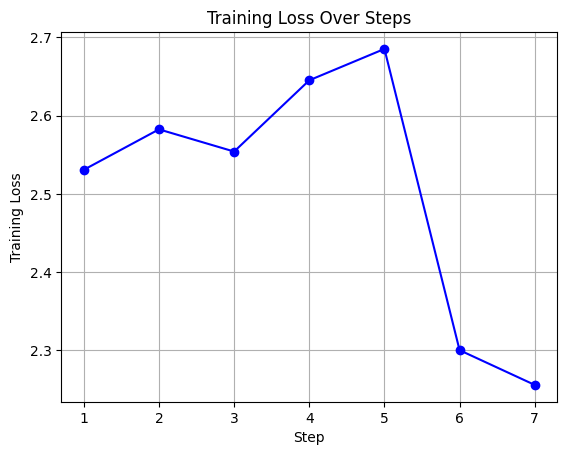

In [11]:
import matplotlib.pyplot as plt

# Training loss data
step = [1, 2, 3, 4, 5, 6, 7]
training_loss = [2.530700, 2.582400, 2.554000, 2.645100, 2.685200, 2.300100, 2.255700]

# Plot the training loss
plt.plot(step, training_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

In [81]:
peft_training_args = TrainingArguments(
    output_dir='./results_model2',
    # num_train_epochs=2,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=2,
    max_steps=6,
    weight_decay=0.01,
    logging_dir='./logs2',
)


peft_trainer2 = Trainer(
    model=peft_model2,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"]
)


In [ ]:
peft_trainer2.train()

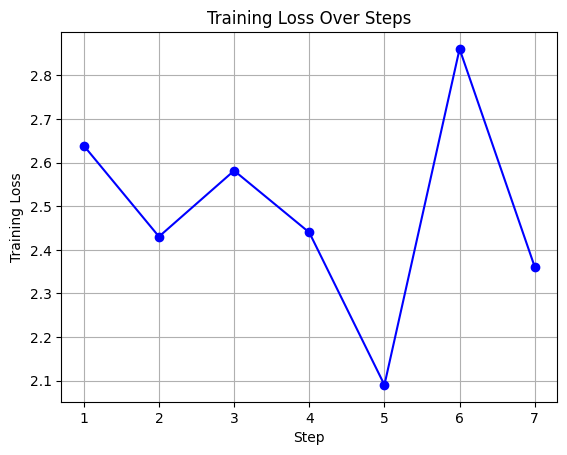

In [10]:
import matplotlib.pyplot as plt

# Training loss data
step = [1, 2, 3, 4, 5, 6, 7]
training_loss = [2.638600, 2.430200, 2.581400, 2.439700, 2.090300, 2.860400, 2.360800]

# Plot the training loss
plt.plot(step, training_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Results

In [116]:
tokenizer = AutoTokenizer.from_pretrained("stabilityai/stablelm-3b-4e1t", use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained("stabilityai/stablelm-3b-4e1t", torch_dtype=torch.bfloat16,use_auth_token=True, trust_remote_code=True)

/root/miniconda3/envs/whisper_asr/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:703: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/root/miniconda3/envs/whisper_asr/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [ ]:
model.to("cuda:0")
model.eval()

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_r = 16  
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "v_proj"
]


peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

peft_model1 = get_peft_model(model, peft_config)
number_of_trainable_model_parameters(peft_model1)

In [ ]:
peft_model1 = PeftModel.from_pretrained(peft_model1, 
                                       './results_model1/', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [ ]:
peft_model2 = PeftModel.from_pretrained(peft_model2, 
                                       './results_model2/', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [ ]:
peft_model1.to("cuda:0")
peft_model1.eval()
peft_model2.to("cuda:0")
peft_model2.eval()
print("peft_model loaded")

In [ ]:
dialogues = dataset['test'][0:100]['dialogue']
human_baseline_summaries = dataset['test'][0:100]['summary']

In [113]:
model_summaries_zeroshot = []
model_summaries_oneshot = []
peft_model1_summaries = []
peft_model2_summaries = []

generation_config = GenerationConfig(
    max_length=512, 
    num_beams=1,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.7,

)
for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation accurately:{dialogue}
Summary: 
"""
    
    input_ids = tokenizer(prompt, return_tensors="pt")
    inputs = {key: value.to("cuda:0") for key, value in input_ids.items()} 
    
    input_ids1 = tokenizer(one_shot_prompt, return_tensors="pt")
    inputs1 = {key: value.to("cuda:0") for key, value in input_ids1.items()} 

    human_baseline_text_output = human_baseline_summaries[idx]

    model_outputs = model.generate(input_ids=inputs["input_ids"], generation_config=generation_config)
    model_outputs_text_output = tokenizer.decode(model_outputs[0], skip_special_tokens=True)
    last_summary_part_model_outputs = original_model_text_output.split('Summary: ')[-1] 
    
    model_outputs1 = model.generate(input_ids=inputs1["input_ids"], generation_config=generation_config)
    model_outputs_text_output1 = tokenizer.decode(model_outputs1[0], skip_special_tokens=True)
    last_summary_part_model_outputs1 = original_model_text_output1.split('Summary: ')[-1] 

    peft_model_outputs1 = peft_model1.generate(input_ids=inputs["input_ids"], generation_config=generation_config)
    peft_model_text_output1 = tokenizer.decode(peft_model_outputs1[0], skip_special_tokens=True)
    last_summary_part1 = peft_model_text_output1.split('Summary: ')[-1] 

    peft_model_outputs2 = peft_model2.generate(input_ids=inputs["input_ids"], generation_config=generation_config)
    peft_model_text_output2 = tokenizer.decode(peft_model_outputs2[0], skip_special_tokens=True)
    last_summary_part2 = peft_model_text_output2.split('Summary: ')[-1] 
    
    model_summaries_zeroshot.append(last_summary_part_model_outputs)
    model_summaries_oneshot.append(last_summary_part_model_outputs1)

    peft_model_summaries1.append(last_summary_part1)
    peft_model_summaries2.append(last_summary_part2)

zipped_summaries = list(zip(human_baseline_summaries, model_summaries_zeroshot, peft_model1_summaries, peft_model2_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'model_zero-shot','model_one-shot', 'peft_model1_summaries','peft_model2_summaries'])
df.head()

,human_baseline_summaries,model_zero-shot,model_one-shot,peft_model1_summaries,peft_model2_summaries
0,\n\n Customer is complaining about parcel s...,\n\n The customer is upset that the deliver...,"\n\n ""Customer enquired about his Iphone an...",\n\n The user is unhappy with the parcel se...,\n\n User is complaining about the bad serv...


In [115]:
import evaluate
rouge = evaluate.load('rouge')

In [1]:

model_results_zeroshot = rouge.compute(
    predictions=model_summaries_zeroshot,
    references=human_baseline_summaries[0:len(model_summaries_zeroshot)],
    use_aggregator=True,
    use_stemmer=True,
)


model_results_oneshot = rouge.compute(
    predictions=model_summaries_oneshot,
    references=human_baseline_summaries[0:len(model_summaries_oneshot)],
    use_aggregator=True,
    use_stemmer=True,
)


peft_model_results1 = rouge.compute(
    predictions=peft_model1_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries1)],
    use_aggregator=True,
    use_stemmer=True,
)
peft_model_results2 = rouge.compute(
    predictions=peft_model2_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries2)],
    use_aggregator=True,
    use_stemmer=True,
)

print('MODEL_zeroshot:')
print(model_results_zeroshot)
print('MODEL_oneshot:')
print(model_results_oneshot)
print('PEFT MODEL with r=16:')
print(peft_model_results1)
print('PEFT MODEL with r=32:')
print(peft_model_results2)

MODEL_zeroshot:
{'rouge1': 0.27536307411265154, 'rouge2': 0.07397794309342791, 'rougeL': 0.1745382837665075, 'rougeLsum': 0.199271106488691}
MODEL_oneshot:
{'rouge1': 0.27226136986216337, 'rouge2': 0.06909427214734443, 'rougeL': 0.17544978177826087, 'rougeLsum': 0.1971415170385126}
PEFT MODEL with r=16:
{'rouge1': 0.28749764092124547, 'rouge2': 0.09970202252113097, 'rougeL': 0.20465062765641967, 'rougeLsum': 0.180644881330203}
None
PEFT MODEL with r=32:
{'rouge1': 0.30121669950569796, 'rouge2': 0.10839891415333017, 'rougeL': 0.21247028930948508, 'rougeLsum': 0.1939035231697902}
